In [1]:
import numpy as np
from numpy.random import randn, permutation, seed
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import time

In [2]:
import sys
sys.path.append("..")
from pp5.stats import tw_test

In [3]:
def W2(mux,muy, Cx, Cy):
    """
    Wasserstein distance between two normal distributions
    """
    return np.sqrt(
        max(0, norm(mux-muy)**2 + np.trace( Cx + Cy - 2*sqrtm(sqrtm(Cx) @ Cy @ sqrtm(Cx)) ))
    )

In [4]:
def gen_random_data(n, nx, ny, shift, covdiff):
    # first-order statistics
    mu_x = randn(n)
    dmu = randn(n)
    mu_y = mu_x + dmu*shift/norm(dmu)

    # second-order statistics
    #A = randn(n, n)
    A = np.abs(np.diag(randn(n)))
    Cx = A @ A.T
    dA = np.abs(randn(n))
    B = A + np.diag(dA/norm(dA)*covdiff)
    Cy = B @ B.T

    # Generate random samples from normal distribution
    X = A @ randn(n, nx) + mu_x[:,None]
    Y = B @ randn(n, ny) + mu_y[:,None]
    
    return X, Y, mu_x, Cx, mu_y, Cy 

In [5]:
print(f"dims\t|mux-muy|\tW2(Cx,Cy)\tNx\tNy\tT2\tp\t\t\ttime(ms)")

RESULTS = []

n  = 5       # number of dimensions
trials = 10
for shift in np.linspace(0,2,11):
    for covdiff in (0,): #(0,0.1,1.,2.):   # uncomment for heteroschedasticity 
        for nx in (10,50,100,):     # number of samples in X
            for ny in (10,50,100,):
                if ny < nx: 
                    continue
                ps = []
                times = []
                for trial in range(trials):
                    seed(trial)
                    X, Y, mu_x, Cx, mu_y, Cy = gen_random_data(n, nx, ny, shift, covdiff)
                    w2 = W2(mu_x*0,mu_y*0, Cx, Cy)
                    t_start = time.time()
                    t2, p = tw_test(X,Y,k=1000)
                    t_end = time.time()
                    ps.append(p)
                    times.append(1000*(t_end-t_start))
                p_mean, p_std = np.mean(ps), np.std(ps)
                time_mean, time_std = np.mean(times), np.std(times)
                print(f"{n:<2}\t{shift:<4.2f}\t\t{w2:<4.2f}\t\t{nx:<4}\t{ny:<4}\t{t2:<6.2f}\t{p_mean:<8.6f}±{p_std:<8.6f}\t{time_mean:.2f}±{time_std:.2f}")
                RESULTS.append( ((nx,ny), shift, p_mean, p_std) )

dims	|mux-muy|	W2(Cx,Cy)	Nx	Ny	T2	p			time(ms)
5 	0.00		0.00		10  	10  	0.41  	0.615100±0.255964	39.52±2.65
5 	0.00		0.00		10  	50  	0.37  	0.720100±0.203110	45.18±1.77
5 	0.00		0.00		10  	100 	0.47  	0.631400±0.211083	64.76±3.97
5 	0.00		0.00		50  	50  	0.26  	0.632900±0.319203	63.68±2.05
5 	0.00		0.00		50  	100 	0.22  	0.670200±0.262467	81.44±3.23
5 	0.00		0.00		100 	100 	0.42  	0.413200±0.252850	105.10±3.99
5 	0.20		0.00		10  	10  	0.46  	0.590400±0.256463	41.14±3.51
5 	0.20		0.00		10  	50  	0.43  	0.638100±0.189404	47.80±3.89
5 	0.20		0.00		10  	100 	0.61  	0.564200±0.201665	65.35±2.96
5 	0.20		0.00		50  	50  	0.49  	0.521500±0.302366	61.49±3.45
5 	0.20		0.00		50  	100 	0.59  	0.430100±0.262539	80.77±3.76
5 	0.20		0.00		100 	100 	0.99  	0.263100±0.209522	104.64±4.71
5 	0.40		0.00		10  	10  	0.56  	0.514100±0.264871	39.72±1.97
5 	0.40		0.00		10  	50  	0.54  	0.511900±0.235512	45.05±1.59
5 	0.40		0.00		10  	100 	0.79  	0.450600±0.228070	63.63±1.63
5 	0.40		0.00		50  	50  	0.97  	0.29

<ipython-input-6-8ee8320de216>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  R = np.array(RESULTS)


Text(0, 0.5, 'Significance')

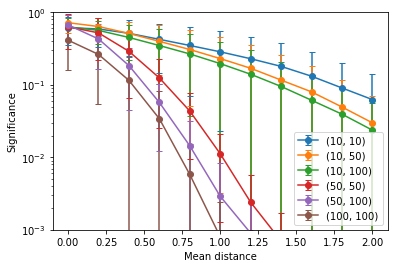

In [6]:
R = np.array(RESULTS)
plt.figure()
for n in np.unique(R[:,0]):
    idx = [r==n for r in R[:,0]]
    plt.errorbar(R[idx,1],R[idx,2],yerr=R[idx,3],capsize=3, marker='o')
plt.legend(np.unique(R[:,0]))
plt.yscale('log')
plt.ylim([1e-3,1])
plt.xlabel('Mean distance')
plt.ylabel('Significance')

In [8]:
X, Y, mu_x, Cx, mu_y, Cy = gen_random_data(n=5, nx=100, ny=100, shift=5, covdiff=2)

%timeit tw_test(X,Y,k=1000)

118 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
